In [1]:
!pip install pytorch-lightning
!pip install tensorboard
!pip install timm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_11368/211975554.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Global seed set to 42


Device: cuda:0


In [3]:
from torchvision import  transforms

In [4]:
transformImg = transforms.Compose([#transforms.Resize((96,96)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda t: t / 255.)
                               ])

postprocess = transforms.Compose([
     transforms.Lambda(lambda t: t.cpu().squeeze(0) * 255.),
     transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
])


In [5]:
import torch.utils.data as baseData
import torch
from torch.utils.data import DataLoader
import pickle

class FaceKeypointsData(baseData.Dataset):
    def __init__(self,ds_path,img_sz=512):
        super(FaceKeypointsData, self).__init__()
        self.img_sz=img_sz
        with open(ds_path, 'rb') as handle:
            self.ds=pickle.load(handle)
        
    def __getitem__(self, index):
        
        img = self.ds["images"][index]
        kps = self.ds["keypoints"][index]
        img=transformImg(img)
        c,h,w=img.shape
        kps=torch.tensor(kps,dtype=torch.float32)/h
        ## reshape to nx2
        kps=kps.reshape(15,-1)
        return img,kps
    
    def __len__(self):
        return len(self.ds["images"])

In [6]:
train_dataset=FaceKeypointsData("../data/train.pkl")
len(train_dataset)

7049

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True) 

In [8]:
img,kps=train_dataset[1]
img.shape,kps.shape,img.min(),img.max(),kps.min(),kps.max()

(torch.Size([1, 96, 96]),
 torch.Size([15, 2]),
 tensor(0.),
 tensor(1.),
 tensor(0.1757),
 tensor(0.8904))

In [9]:
def viskps(imgs,kps):
    import cv2
    kps=kps.detach().cpu()
    n,x,h,w=imgs.shape
    visimgs=[]
    for idx in range(n):
        visimg=postprocess(imgs[idx])
        visimg=cv2.cvtColor(visimg, cv2.COLOR_GRAY2RGB)
        viskps=kps.cpu().numpy()
        for i in range(len(viskps[idx])):
            point=(int(viskps[idx][i][0]*h),int(viskps[idx][i][1]*h))
            visimg=cv2.circle(visimg,point,1,(255,0,255),-1)
        visimgs.append(torch.tensor(visimg))
    visimgs=torch.stack(visimgs,axis=0).float()
    return visimgs
    

In [10]:
def get_train_data(num):
    imgs=torch.stack([train_dataset[i][0] for i in range(num)], dim=0)
    kps=torch.stack([train_dataset[i][1] for i in range(num)], dim=0)
    return (imgs,kps)

torch.Size([16, 3, 96, 96])


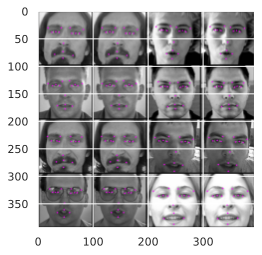

In [11]:

#imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
import cv2
imgs,kps=get_train_data(8)
visimgs=viskps(imgs,kps)
#plt.imshow(visimgs[0])
gtvisimgs=visimgs.permute(0, 3, 1, 2)
predvisimgs=gtvisimgs
gridimgs=torch.stack([gtvisimgs/255,predvisimgs/255],dim=1).flatten(0,1)
print(gridimgs.shape)
grid = torchvision.utils.make_grid(gridimgs, nrow=4, normalize=True, value_range=(0,1))
plt.imshow(grid.permute(1,2,0))
#imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
#grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))

In [12]:
class VisCallback(pl.Callback):

    def __init__(self, every_n_epochs=1):
        super().__init__()
        input_imgs,kps=get_train_data(8)
        self.input_imgs = input_imgs # Images for visulaization
        self.kps=kps
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            gtimgs=viskps(input_imgs,self.kps)
            gtimgs=gtimgs.permute(0, 3, 1, 2)/255
            with torch.no_grad():
                pl_module.eval()
                pred_kps = pl_module(input_imgs)
                pl_module.train()
            predimgs=viskps(input_imgs,pred_kps)
            predimgs=predimgs.permute(0, 3, 1, 2)/255
            # Plot and add to tensorboard
            imgs = torch.stack([gtimgs, predimgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Predicted KeyPoints", grid, global_step=trainer.global_step)

In [13]:
import torch
import timm

In [14]:
encoder = timm.create_model('cspresnet50',features_only=True, pretrained=True,in_chans=1,output_stride=8)

In [15]:
o = encoder(torch.randn(2, 1, 96, 96))
for x in o:
    print(x.shape)

torch.Size([2, 64, 48, 48])
torch.Size([2, 128, 24, 24])
torch.Size([2, 256, 12, 12])
torch.Size([2, 512, 12, 12])
torch.Size([2, 1024, 12, 12])


In [16]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = timm.create_model('cspresnet50',features_only=True, pretrained=True,in_chans=1,output_stride=8)


    def forward(self, x):
        return self.encoder(x)[-1]

In [17]:
class Decoder(nn.Module):

    def __init__(self,
                 c_hid : int,
                 out_points: int=15,
                 layers: int=6,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        
        c_inter=c_hid//4
        self.out_points=out_points

        interModules=[]
        for _ in range(layers):
            interModules.append(nn.Conv2d(c_inter, c_inter, kernel_size=3, padding=1))
            interModules.append(act_fn())
        
        self.net = nn.Sequential(
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, c_inter, kernel_size=3, padding=1),
            act_fn(),
            *interModules,
            nn.Conv2d(c_inter, out_channels=out_points*2, kernel_size=3, padding=1),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.net(x)
        x=x.reshape(-1,self.out_points,2)
        return x

In [18]:
CHECKPOINT_PATH="face_kps_checkpoints"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [19]:
class KeyPointModel(pl.LightningModule):

    def __init__(self,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 1,
                 width:int= 96,
                 height:int= 96):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class()
        self.decoder = decoder_class(latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_MSE_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, y = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(y, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2]).mean(dim=[0])
        return loss
    

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_MSE_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

In [20]:
model=KeyPointModel(1024)
x=torch.rand(32,1,96,96)
model(x).shape

torch.Size([32, 15, 2])

In [21]:
for batch in train_loader:
    imgs=batch[0]
    kps=batch[1]
    print(imgs.shape)
    print(kps.shape)
    break


torch.Size([32, 1, 96, 96])
torch.Size([32, 15, 2])


In [22]:
def train_keypoints(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"face_kps_{latent_dim}"),
                         accelerator="cuda" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=300,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    VisCallback(every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"face_kps_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = KeyPointModel.load_from_checkpoint(pretrained_filename)
    else:
        model = KeyPointModel(latent_dim=latent_dim)
        trainer.fit(model, train_loader)
    # Test best model on validation and test set
    #val_result = trainer.test(model, val_loader, verbose=False)
    #test_result = trainer.test(model, test_loader, verbose=False)
    #result = {"val": val_result}
    return model

In [23]:
model=train_keypoints(1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes          | Out sizes        
----------------------------------------------------------------------------
0 | encoder | Encoder | 17.6 M | [2, 1, 96, 96]    | [2, 1024, 12, 12]
1 | decoder | Decoder | 15.4 M | [2, 1024, 12, 12] | [2, 15, 2]       
----------------------------------------------------------------------------
33.0 M    Trainable params
0         Non-trainable params
33.0 M    Total params
132.167   Total estimated model params size (MB)
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site

Training: 0it [00:00, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


MisconfigurationException: ReduceLROnPlateau conditioned on metric val_loss which is not available. Available metrics are: ['train_loss']. Condition can be set using `monitor` key in lr scheduler dict